# Load Dataset

In [ ]:
!pip install nltk wordcloud

In [ ]:
import os
import numpy as np
import pandas as pd
import itertools
import re
import gc
import string
import warnings
import operator
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from scipy.stats import norm, skew, mode

from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping
from keras.metrics import Precision, Recall
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
file_path = "/content/Womens Clothing E-Commerce Reviews (1).csv"
data = pd.read_csv(file_path)

print("Dataset Information:")
data.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [ ]:
data.describe(include='all')

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
count,23486.000000,23486.000000,23486.000000,19676,22641,23486.000000,23486.000000,23486.000000,23472,23472,23472
unique,NaN,NaN,NaN,13993,22634,NaN,NaN,NaN,3,6,20
top,NaN,NaN,NaN,Love it!,Perfect fit and i've gotten so many compliment...,NaN,NaN,NaN,General,Tops,Dresses
freq,NaN,NaN,NaN,136,3,NaN,NaN,NaN,13850,10468,6319
mean,11742.500000,918.118709,43.198544,NaN,NaN,4.196032,0.822362,2.535936,NaN,NaN,NaN
std,6779.968547,203.298980,12.279544,NaN,NaN,1.110031,0.382216,5.702202,NaN,NaN,NaN
min,0.000000,0.000000,18.000000,NaN,NaN,1.000000,0.000000,0.000000,NaN,NaN,NaN
25%,5871.250000,861.000000,34.000000,NaN,NaN,4.000000,1.000000,0.000000,NaN,NaN,NaN
50%,11742.500000,936.000000,41.000000,NaN,NaN,5.000000,1.000000,1.000000,NaN,NaN,NaN
75%,17613.750000,1078.000000,52.000000,NaN,NaN,5.000000,1.000000,3.000000,NaN,NaN,NaN


In [ ]:
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
nltk.download('punkt')  # Tokenizer Models
nltk.download('stopwords')  # Stopwords List
nltk.download('wordnet')  # Lemmatization Dictionary

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Clean

In [ ]:
df = data.copy()

### Missing

In [ ]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [ ]:
col_with_missing = [c for c in df.columns if df[c].isnull().sum() >= 1]
missing_counts = df[col_with_missing].isnull().sum().sort_values(ascending=False)
total_rows = len(df)
missing_percentages = (missing_counts / total_rows) * 100

<ipython-input-10-324f22412635>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, missing_percentages[i] + 1, f"{count} ({missing_percentages[i]:.1f}%)", ha='center')


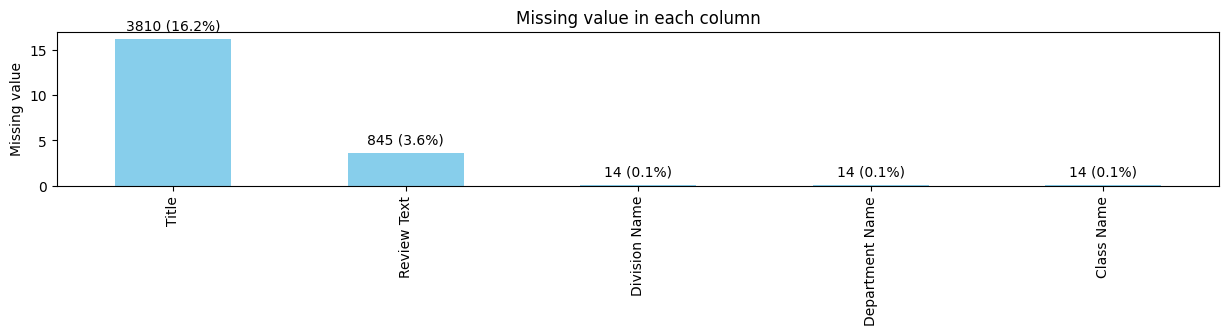

In [ ]:
#plot
plt.figure(figsize=(15, 2))
ax = missing_percentages.plot.bar(color='skyblue')

for i, (col, count) in enumerate(zip(missing_counts.index, missing_counts)):
    ax.text(i, missing_percentages[i] + 1, f"{count} ({missing_percentages[i]:.1f}%)", ha='center')

plt.ylabel("Missing value")
plt.title("Missing value in each column")
plt.show()

In [ ]:
print("Rows before deleting missing values in review text: ", df.shape[0])

df.dropna(subset=["Review Text"], inplace=True)
df.reset_index(drop=True, inplace=True)

print("Rows after deleting missing values in review text: ", df.shape[0])

Rows before deleting missing values in review text:  23486
Rows after deleting missing values in review text:  22641


In [ ]:
# Fill in missing values with blank for other object type columns
col_with_missing.remove('Review Text')
for c in col_with_missing:
    if c=='Title':
           df[c] =df[c].fillna(' ')
    else:
           df[c]=df[c].fillna('Blank')

df.isna().sum().sum()

0

### Duplicate

In [ ]:
print(f"Rows with duplicates: {df.duplicated().sum()}")

Rows with duplicates: 1


In [ ]:
# Drop duplicates
df.drop_duplicates(inplace=True)
print(f"Rows in df after dropping duplicates: {df.shape[0]}")

Rows in df after dropping duplicates: 22640


In [ ]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


# EDA

## Description


In [ ]:
# Check total Cloth items in dataset
print("Clothing Item Counts in dataset: ", len(df["Clothing ID"].unique()))

Clothing Item Counts in dataset:  1179


In [ ]:
col_cont=[]
col_disc=[]
col_text=[]

for c in df.columns:
    if (c in ['Review Text','Title']):
        col_text.append(c)
    elif (df[c].dtype=='object') or c=='Rating' or c=="Recommended IND":
        col_disc.append(c)
    else:
        col_cont.append(c)

#Take a look at features
print(f"Continuous features:\n {col_cont}")
print(f"Discrete features:\n {col_disc}")
print(f"Text features:\n {col_text}")

Continuous features:
 ['Clothing ID', 'Age', 'Positive Feedback Count']
Discrete features:
 ['Rating', 'Recommended IND', 'Division Name', 'Department Name', 'Class Name']
Text features:
 ['Title', 'Review Text']


### Continuous features

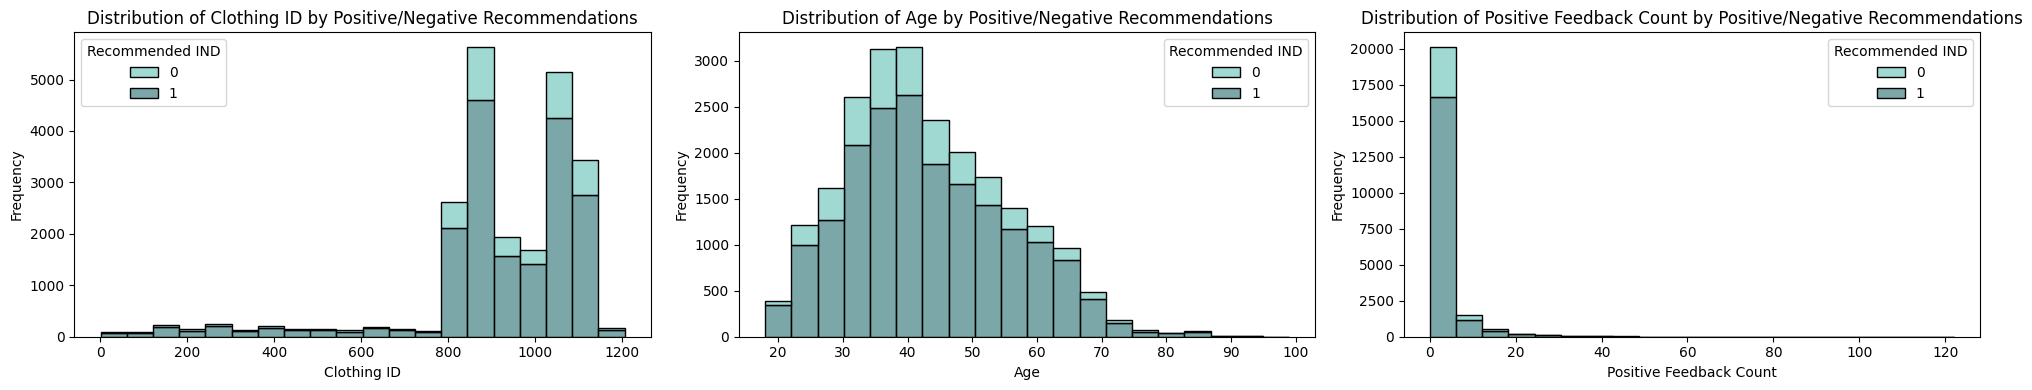

In [ ]:
# Continuous Features - histogram by recommend ID
warnings.filterwarnings("ignore", category=FutureWarning)

# Define actual continuous features from your dataset
col_cont = ['Clothing ID', 'Age', 'Positive Feedback Count']  # Use real numerical column names

# Create a single row with 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 4))  # 1 row, 3 columns

# Loop through each feature and plot
for idx, feature in enumerate(col_cont):
    sns.histplot(data=df, x=feature, hue='Recommended IND', bins=20, ax=ax[idx],
                 palette=['#80CBC4', '#4F8A8B'], multiple='stack')
    ax[idx].set_title(f'Distribution of {feature} by Positive/Negative Recommendations', fontsize=12)
    ax[idx].set_xlabel(feature, fontsize=10)
    ax[idx].set_ylabel('Frequency', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

<ipython-input-19-fa95e2ff1e24>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


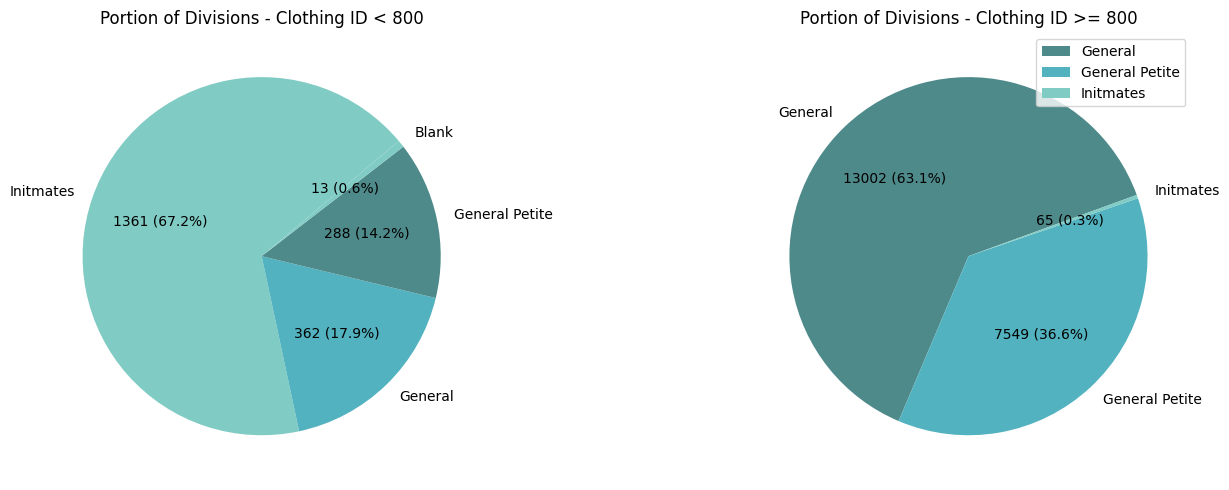

In [ ]:
# Pie chart by Clothing ID <800 and >800
df_clothing_0 = df[df['Clothing ID'] < 800]
df_clothing_1 = df[df['Clothing ID'] >= 800]

colors_0=['#80CBC4', '#52B2BF', '#4F8A8B']
colors_1=['#4F8A8B', '#52B2BF', '#80CBC4']
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Pie chart for clothing ID < 800
clothing_0 = df_clothing_0['Division Name'].value_counts()
ax[0].pie(clothing_0, labels=clothing_0.index, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(clothing_0) / 100, p), colors=colors_0, startangle=40)
ax[0].set_title('Portion of Divisions - Clothing ID < 800')
plt.legend()

# Pie chart for clothing ID >= 800
clothing_1 = df_clothing_1['Division Name'].value_counts()
ax[1].pie(clothing_1, labels=clothing_1.index, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(clothing_1) / 100, p),colors=colors_1, startangle=20)
ax[1].set_title('Portion of Divisions - Clothing ID >= 800')
plt.legend()

plt.tight_layout()
plt.show()

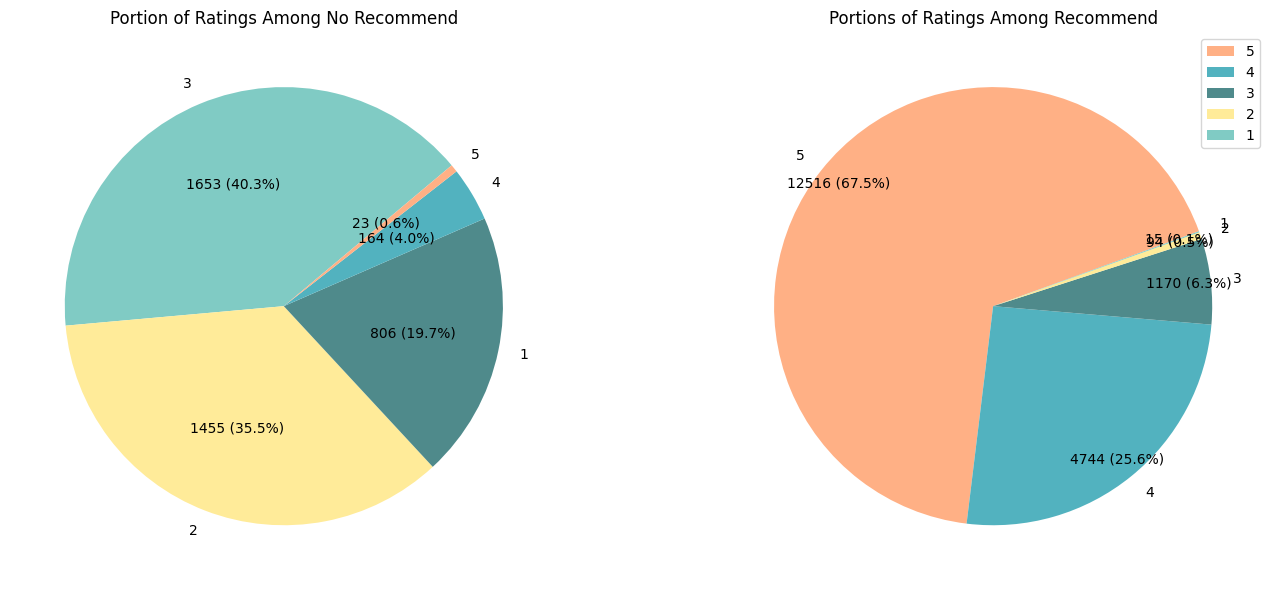

In [ ]:
# Pie plot by Ratings
df_recommended_0 = df[df['Recommended IND'] == 0]
df_recommended_1 = df[df['Recommended IND'] == 1]
colors_0=['#80CBC4', '#FFEB99', '#4F8A8B', '#52B2BF', '#FFB085']
colors_1=['#FFB085', '#52B2BF', '#4F8A8B', '#FFEB99', '#80CBC4'] #order of 54321

# Create two subplots for the pie charts
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart for Recommended IND = 0
sizes_0 = df_recommended_0['Rating'].value_counts()
ax[0].pie(sizes_0, labels=sizes_0.index, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(sizes_0) / 100, p), colors=colors_0,startangle=40)
ax[0].set_title('Portion of Ratings Among No Recommend')

# Pie chart for Recommended IND = 1
sizes_1 = df_recommended_1['Rating'].value_counts()
ax[1].pie(sizes_1,labels=sizes_1.index, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(sizes_1) / 100, p), colors=colors_1,startangle=20,pctdistance=0.9)
ax[1].set_title('Portions of Ratings Among Recommend')
plt.legend()
plt.tight_layout()
plt.show()

## Recommendation Distribution

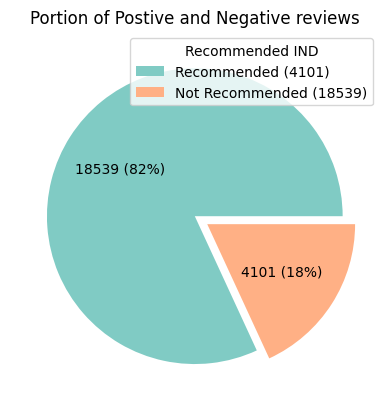

In [ ]:
from pickle import NONE
sizes = df['Recommended IND'].value_counts()
#labels = ["1", "0"]
explode = (0, 0.1)  #pull out second slice by 10%
colors = ['#80CBC4', '#FFB085']
plt.pie(x=sizes, labels=None, explode=explode, autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * sum(sizes) / 100, p), colors=colors)
plt.title('Portion of Postive and Negative reviews')
plt.legend(title="Recommended IND", loc="upper right", labels=[f"Recommended ({sizes[0]})", f"Not Recommended ({sizes[1]})"])
plt.show()

## Distribution of Ratings

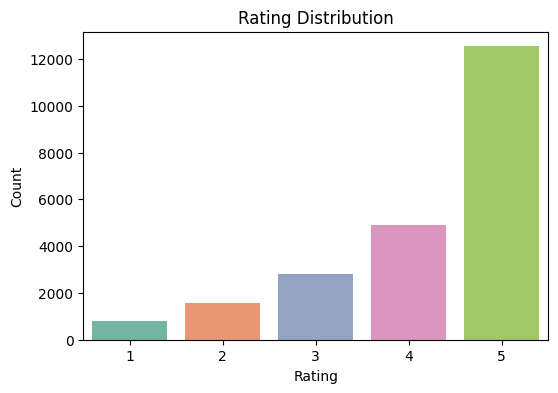

In [ ]:
#Distribution of Ratings
plt.figure(figsize=(6,4))
sns.countplot(x=df["Rating"], palette='Set2')
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

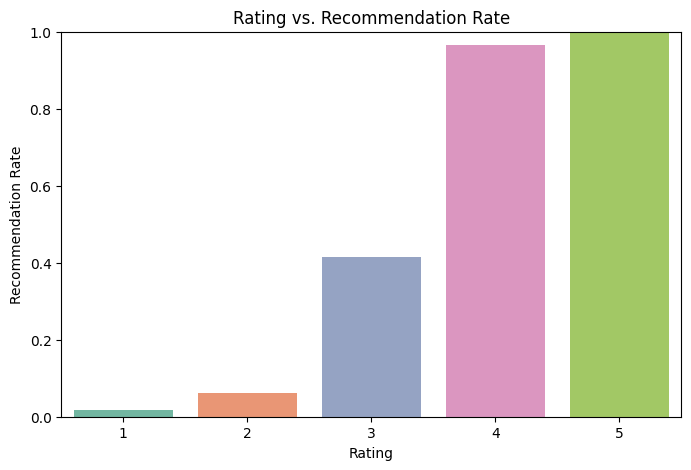

In [ ]:
#Relationship between Rating and Recommendation
plt.figure(figsize=(8,5))

# Compute the recommendation rate for each rating
recommendation_rates = df.groupby("Rating")["Recommended IND"].mean().reset_index()

sns.barplot(x="Rating", y="Recommended IND", data=recommendation_rates, palette="Set2")

plt.title("Rating vs. Recommendation Rate")
plt.xlabel("Rating")
plt.ylabel("Recommendation Rate")
plt.ylim(0, 1)
plt.show()

## % of positive recommendation

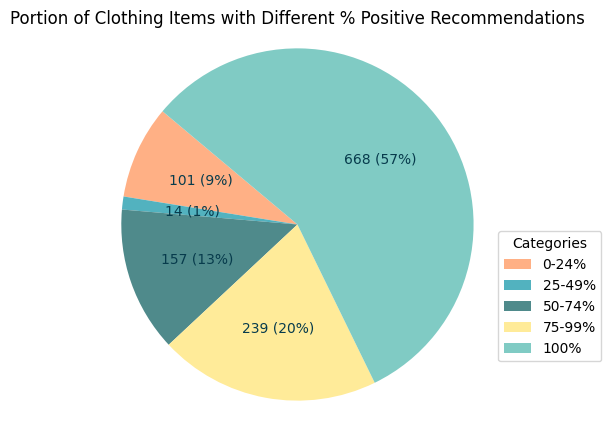

In [ ]:
# Pie chart for % of positive recommendation for each of clothing item

# Calculate the percentage of positive feedback for each clothing item & Bin the data into specified ranges
positive_percentage = (df.groupby('Clothing ID')['Recommended IND'].mean() * 100)
bins = [0, 25, 50, 75, 99, 101]
labels = ['0-24%', '25-49%', '50-74%', '75-99%', '100%']
binned_percentage = pd.cut(positive_percentage, bins=bins, labels=labels, right=False)
colors = ['#FFB085', '#52B2BF', '#4F8A8B', '#FFEB99', '#80CBC4']

# Proportion of items falling into each bin
percentage_counts = binned_percentage.value_counts(normalize=True) * 100
counts = binned_percentage.value_counts()
pr = pd.DataFrame({'Percentage': percentage_counts, 'Count': counts})
pr = pr.reindex(labels)

# Pie Chart
plt.figure(figsize=(5, 5))
wedges, _, autotexts = plt.pie(pr['Percentage'],
                labels=None,  # 移除外部标签
                autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * sum(pr['Count']) / 100, p),
                colors=colors,
                textprops={'color': '#073B4C'},
                startangle=140)

# 添加图例
plt.legend(wedges, labels, title="Categories", loc="upper left", bbox_to_anchor=(1, 0.5))

plt.title('Portion of Clothing Items with Different % Positive Recommendations')
plt.axis('equal')
plt.show()

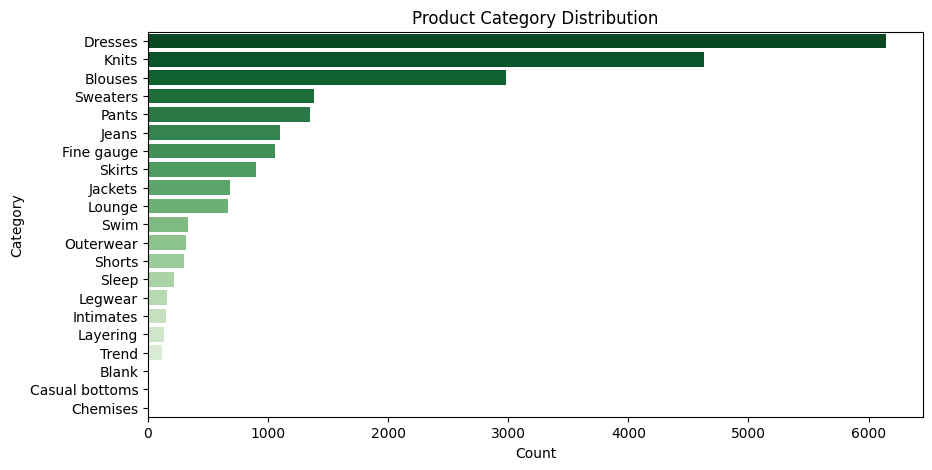

In [ ]:
#Distribution of Product Categories
plt.figure(figsize=(10,5))
sns.countplot(y=df["Class Name"], order=df["Class Name"].value_counts().index, palette="Greens_r")
plt.title("Product Category Distribution")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()

## boxplot

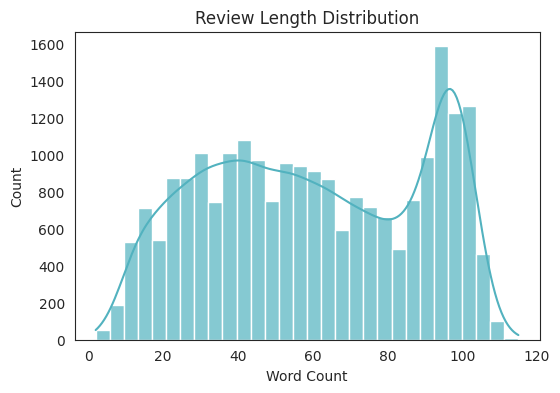

In [ ]:
#Distribution of Review Lengths
df["Review Length"] = df["Review Text"].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
sns.set_style("white")
sns.histplot(df["Review Length"], bins=30, color="#52B2BF", kde=True, alpha=0.7)
plt.title("Review Length Distribution")
plt.xlabel("Word Count")
plt.ylabel("Count")
plt.show()

In [ ]:
palette = sns.color_palette("Set2")


In [ ]:
def get_col_names(dataframe, cat_th = 10, car_th = 20):
    cat_cols = [col for col in df.columns if str(df[col].dtypes) in ["category","object","bool"]]

    num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and df[col].dtypes in ["int64","float64"]]

    cat_but_car = [col for col in df.columns if df[col].nunique() > car_th and str(df[col].dtypes) in ["category","object"]]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in df.columns if df[col].dtypes in ["int64","float64"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols : {len(cat_cols)}")
    print(f"num_cols : {len(num_cols)}")
    print(f"cat_but_car : {len(cat_but_car)}")
    print(f"num_but_cat : {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car

In [ ]:
cat_cols, num_cols, cat_but_car = get_col_names(df)


Observations: 22640
Variables: 11
cat_cols : 4
num_cols : 4
cat_but_car : 3
num_but_cat : 2


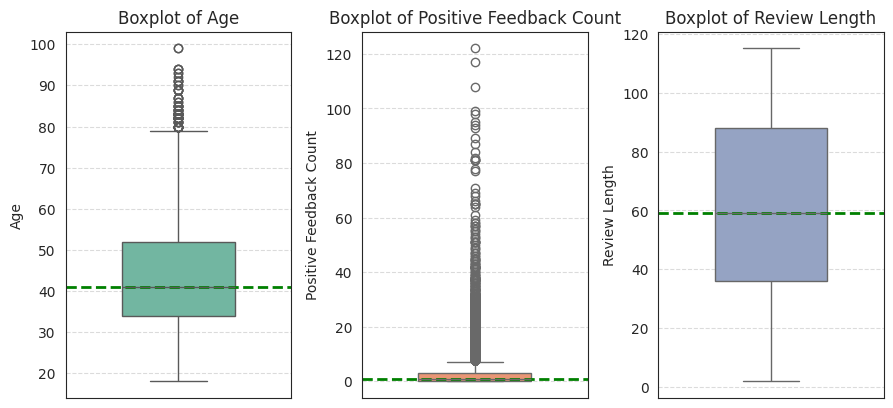

In [ ]:
plt.figure(figsize=(12, 8))
num_cols = [col for col in num_cols if col != "Clothing ID"]

for i, column in enumerate(num_cols, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df[column], color=palette[i-1], width=0.5)
    plt.axhline(y=df[column].median(), color="green", linestyle="--", linewidth=2)
    plt.title(f"Boxplot of {column}", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# Text Mining

## Word Cloud

In [ ]:
#Word Cloud for Most Frequent Words
def clean_text(text):
    """
    Preprocess text by:
    - Converting to lowercase
    - Removing punctuation
    - Removing stopwords
    """
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in stopwords.words("english")]  # Remove stopwords
    return " ".join(words)

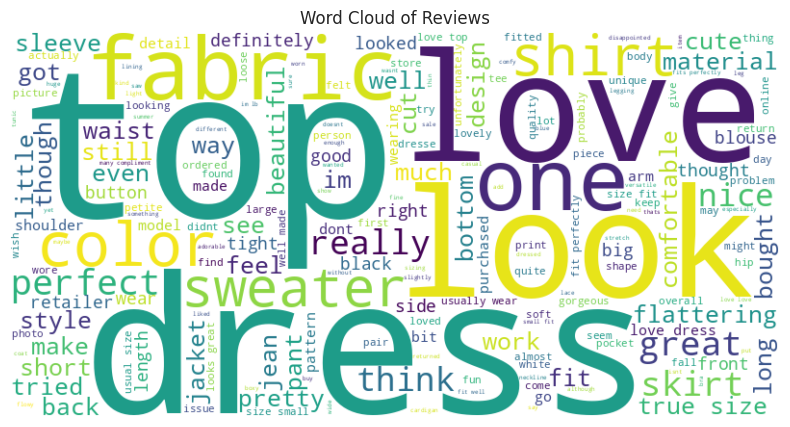

In [ ]:
# Apply text cleaning
df["Cleaned Review"] = df["Review Text"].apply(clean_text)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(df["Cleaned Review"]))

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Reviews")
plt.show()

## Top Word

In [ ]:
# Function to find top N n-grams
def top_n_ngram_one(corpus, n=None, ngram=1):
    vec = CountVectorizer(stop_words='english', ngram_range=(ngram, ngram))
    bag_of_words = vec.fit_transform(corpus)  # Get word counts
    sum_words = bag_of_words.sum(axis=0)  # Sum all word occurrences
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Remove NaN values before passing to function
data_cleaned = df['Review Text'].dropna()

# Run the function on cleaned data
common_words = top_n_ngram_one(data_cleaned, 20, 1)

# Convert to DataFrame
tw1 = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

In [ ]:
# Create a custom color gradient
cmap = LinearSegmentedColormap.from_list("custom_gradient", ["#FFB085", "#80CBC4"])

# Normalize the color mapping to the data points
norm = plt.Normalize(tw1["Frequency"].min(), tw1["Frequency"].max())
ourcolors = [cmap(norm(value)) for value in tw1["Frequency"]]

<ipython-input-18-bdc82953d600>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=tw1['Word'], x=tw1['Frequency'], palette=ourcolors)  # 使用自定义渐变颜色


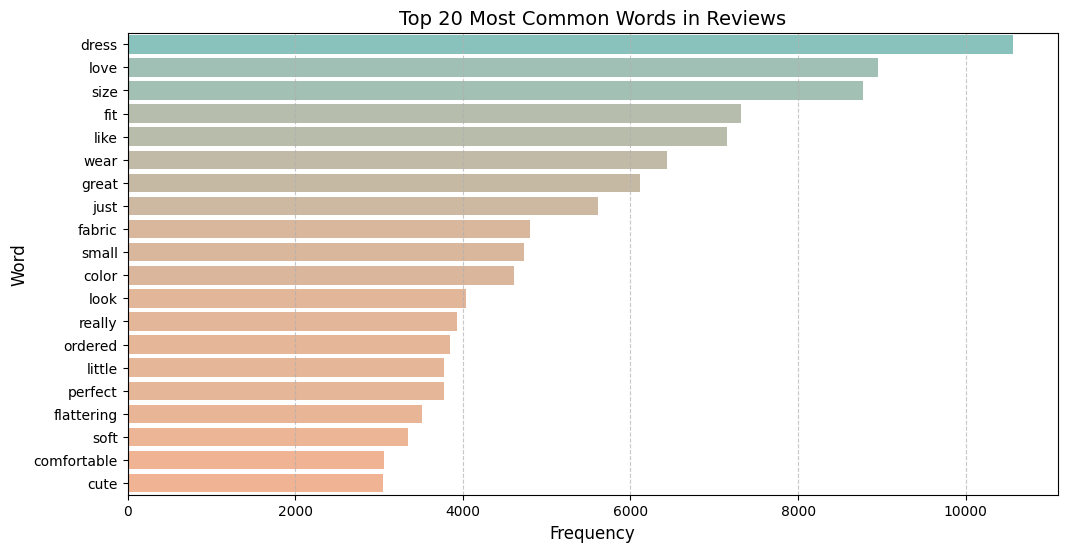

In [ ]:
# Plot the results using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(y=tw1['Word'], x=tw1['Frequency'], palette=ourcolors)  # 使用自定义渐变颜色

# Formatting
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Word", fontsize=12)
plt.title("Top 20 Most Common Words in Reviews", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Adds subtle gridlines

# Show plot
plt.show()

<ipython-input-19-044fe54f3e86>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=tw2['Bigram'], x=tw2['Frequency'], palette=ourcolors)


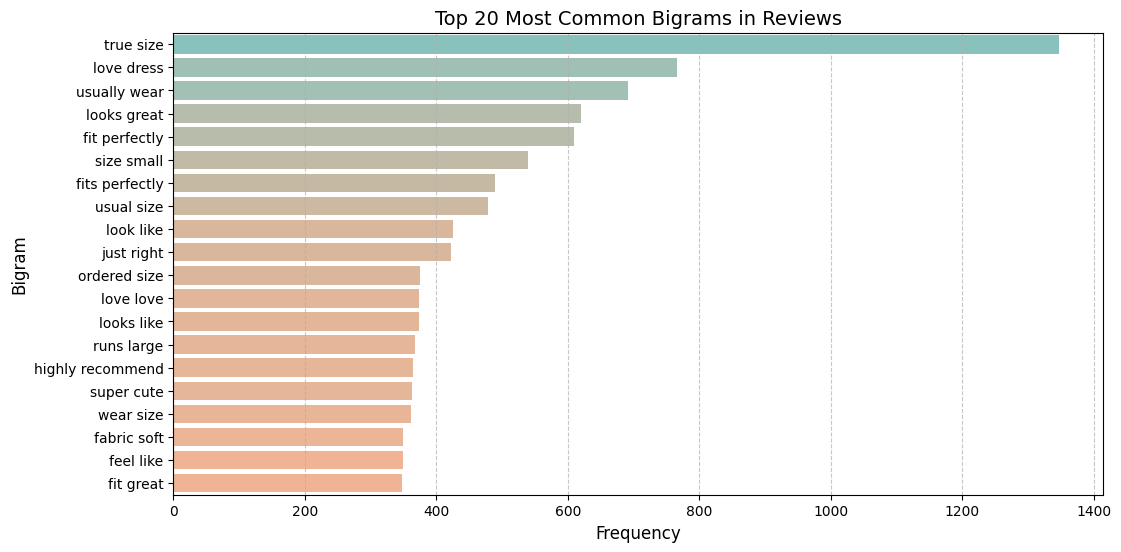

In [ ]:
# Function to find top N n-grams (now for bigrams)
def top_n_ngram_two(corpus, n=None, ngram=2):  # Changed default ngram=2 for bigrams
    vec = CountVectorizer(stop_words='english', ngram_range=(ngram, ngram))
    bag_of_words = vec.fit_transform(corpus)  # Get word counts
    sum_words = bag_of_words.sum(axis=0)  # Sum all word occurrences
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Remove NaN values before passing to function
#data_cleaned = df['Review Text'].dropna()

# Run the function on cleaned data (Now for Bigrams)
common_words = top_n_ngram_two(data_cleaned, 20, 2)

# Convert to DataFrame
tw2 = pd.DataFrame(common_words, columns=['Bigram', 'Frequency'])

# Plot the results using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(y=tw2['Bigram'], x=tw2['Frequency'], palette=ourcolors)

# Formatting
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Bigram", fontsize=12)
plt.title("Top 20 Most Common Bigrams in Reviews", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Adds subtle gridlines

# Show plot
plt.show()


<ipython-input-20-5d88657fe582>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=tw3['Trigram'], x=tw3['Frequency'], palette=ourcolors)


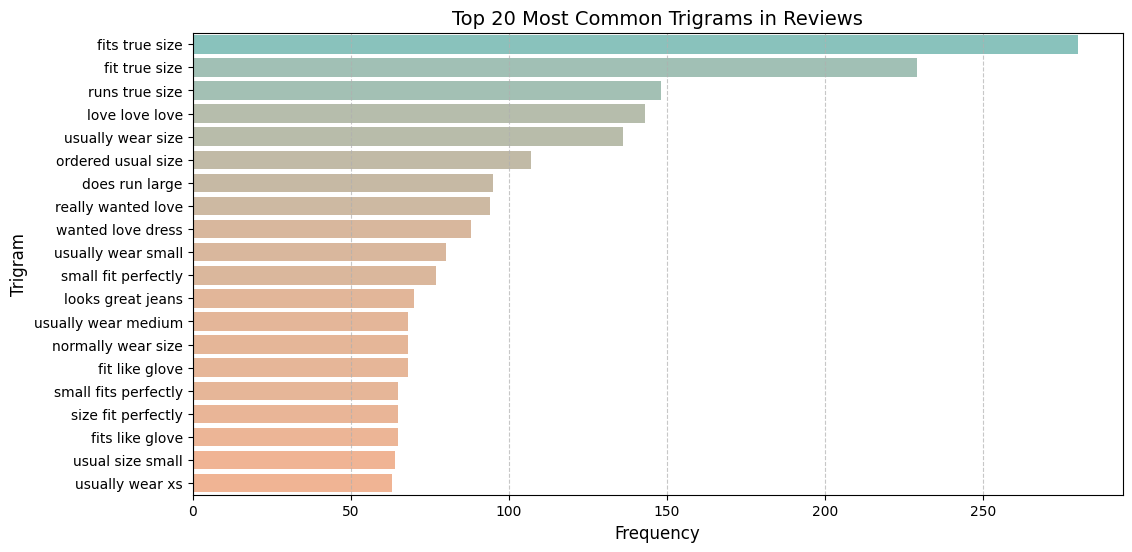

In [ ]:
# Function to find top N n-grams
def top_n_ngram_three(corpus, n=None, ngram=3):  # Set ngram=3 for trigrams
    vec = CountVectorizer(stop_words='english', ngram_range=(ngram, ngram))
    bag_of_words = vec.fit_transform(corpus)  # Get word counts
    sum_words = bag_of_words.sum(axis=0)  # Sum all word occurrences
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

#data_cleaned = data['Review Text'].dropna()

common_words = top_n_ngram_three(data_cleaned, 20, 3)

tw3 = pd.DataFrame(common_words, columns=['Trigram', 'Frequency'])

plt.figure(figsize=(12, 6))
sns.barplot(y=tw3['Trigram'], x=tw3['Frequency'], palette=ourcolors)

# Formatting
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Trigram", fontsize=12)
plt.title("Top 20 Most Common Trigrams in Reviews", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Adds subtle gridlines

# Show plot
plt.show()

## Corr

In [ ]:
cor = data.copy()

In [ ]:
cor.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


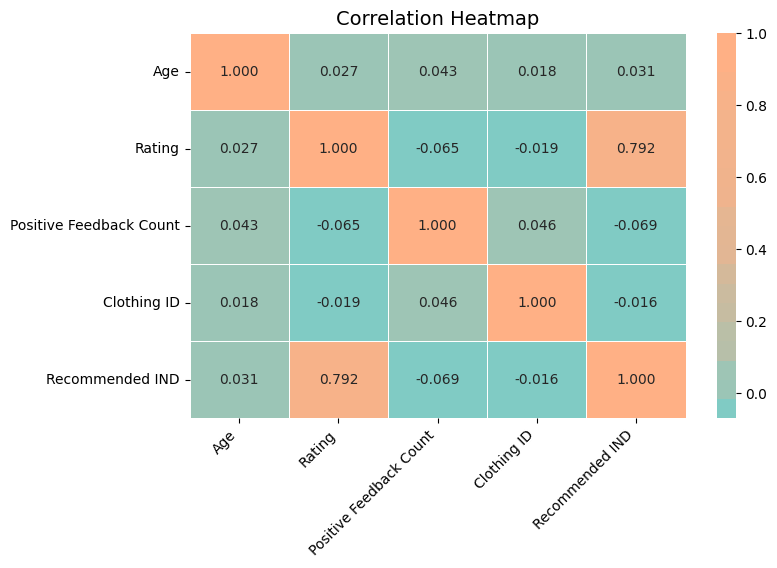

In [ ]:
# Select only the relevant columns
selected_columns = ["Age", "Rating", "Positive Feedback Count", "Clothing ID", "Recommended IND"]  # Adjust if needed
df_selected = cor[selected_columns]

# Compute correlation matrix
correlation_matrix = df_selected.corr()

# Plot heatmap with Green-to-Purple color scheme
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap=ourcolors, fmt=".3f", linewidths=0.5)

# Formatting
plt.title("Correlation Heatmap", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Show plot
plt.show()

# Sentiment Analysis

Classifying reviews as Positive (4-5), Neutral (3), or Negative (1-2)

In [ ]:
sentiment = df.copy()

In [ ]:
df_cleaned = sentiment.dropna(subset=["Review Text"])

df_cleaned = df_cleaned[["Review Text", "Rating", "Recommended IND"]]

def assign_sentiment(rating):
    if rating >= 4:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    else:
        return "Negative"

df_cleaned["Sentiment"] = df_cleaned["Rating"].apply(assign_sentiment)

#stopword
stopwords_path = "/content/stopwords_boschA.txt"
with open(stopwords_path, "r") as file:
    custom_stopwords = set(word.strip() for word in file.readlines())

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in custom_stopwords]
    return " ".join(tokens)

df_cleaned["Cleaned Review"] = df_cleaned["Review Text"].apply(clean_text)

output_path = "/content/Cleaned_Reviews.csv"
df_cleaned.to_csv(output_path, index=False)

df_cleaned.head()

,Review Text,Rating,Recommended IND,Sentiment,Cleaned Review
0,Absolutely wonderful - silky and sexy and comf...,4,1,Positive,absolutely wonderful silky sexy comfortable
1,Love this dress! it's sooo pretty. i happene...,5,1,Positive,love dress sooo pretty happened store glad bc ...
2,I had such high hopes for this dress and reall...,3,0,Neutral,hopes dress initially petite usual size outrag...
3,"I love, love, love this jumpsuit. it's fun, fl...",5,1,Positive,love love love jumpsuit fun flirty fabulous ti...
4,This shirt is very flattering to all due to th...,5,1,Positive,shirt flattering adjustable front tie perfect ...


## visual

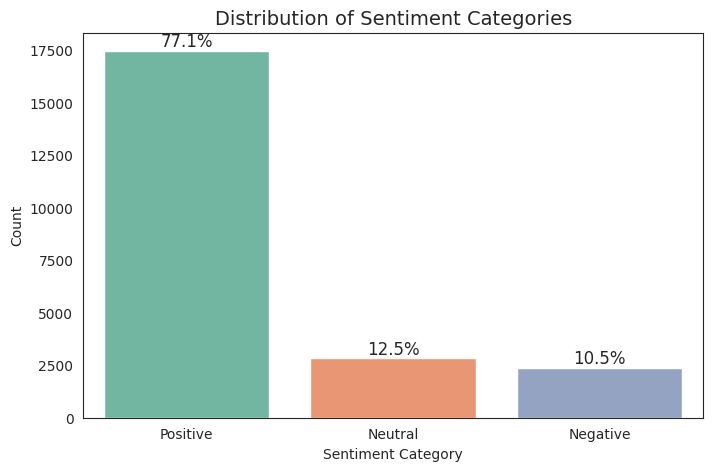

In [ ]:
sentiment_counts = df_cleaned["Sentiment"].value_counts(normalize=True) * 100
sentiment_counts_df = df_cleaned["Sentiment"].value_counts().reset_index()
sentiment_counts_df.columns = ["Sentiment", "Count"]
sentiment_counts_df["Percentage"] = sentiment_counts_df["Sentiment"].map(lambda x: sentiment_counts[x])

plt.figure(figsize=(8, 5))
ax = sns.barplot(x="Sentiment", y="Count", data=sentiment_counts_df, palette="Set2", order=["Positive", "Neutral", "Negative"])

for i, row in sentiment_counts_df.iterrows():
    ax.text(i, row["Count"] + 200, f'{row["Percentage"]:.1f}%', ha='center', fontsize=12)

plt.title("Distribution of Sentiment Categories", fontsize=14)
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.show()

(-0.5, 1289.5, 1919.5, -0.5)

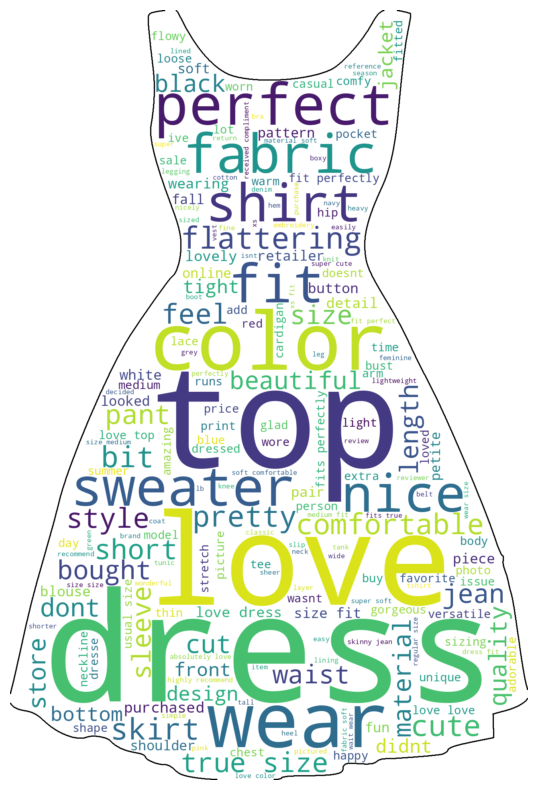

In [ ]:
from PIL import Image
positive_text = " ".join(df_cleaned[df_cleaned["Sentiment"] == "Positive"]["Cleaned Review"])
neutral_text = " ".join(df_cleaned[df_cleaned["Sentiment"] == "Neutral"]["Cleaned Review"])
negative_text = " ".join(df_cleaned[df_cleaned["Sentiment"] == "Negative"]["Cleaned Review"])

custom_mask_path = "/content/dress-294514_1920.png"
custom_mask_image = np.array(Image.open(custom_mask_path).convert("L"))
custom_mask = np.where(custom_mask_image > 128, 255, 0)

wordcloud_positive = WordCloud(
    width=800, height=800, background_color="white",
    mask=custom_mask, contour_color="black", contour_width=2
).generate(positive_text)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis("off")
#plt.title("Word Cloud - Dress Shape (Positive Reviews)", fontsize=14)

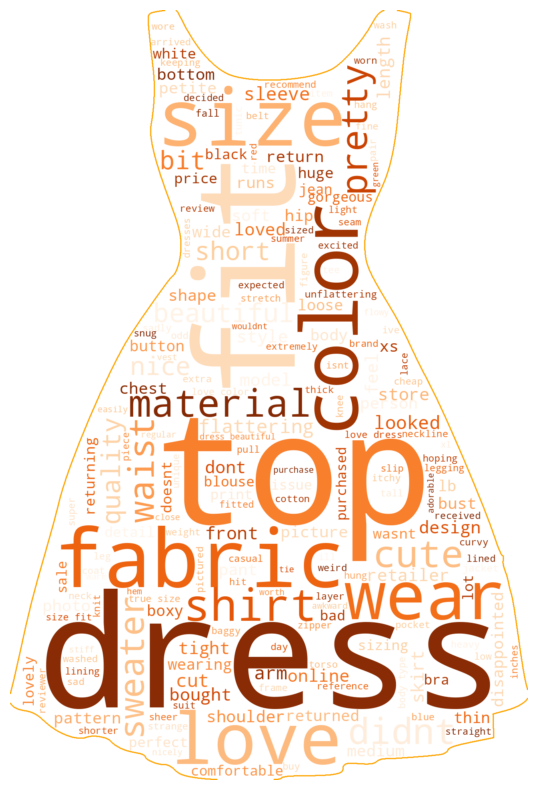

In [ ]:
wordcloud_neutral = WordCloud(
    width=800, height=800, background_color="white",
    colormap="Oranges", mask=custom_mask, contour_color="orange", contour_width=2
).generate(neutral_text)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_neutral, interpolation="bilinear")
plt.axis("off")
#plt.title("Word Cloud - Dress Shape (Neutral Reviews)", fontsize=14)
plt.show()

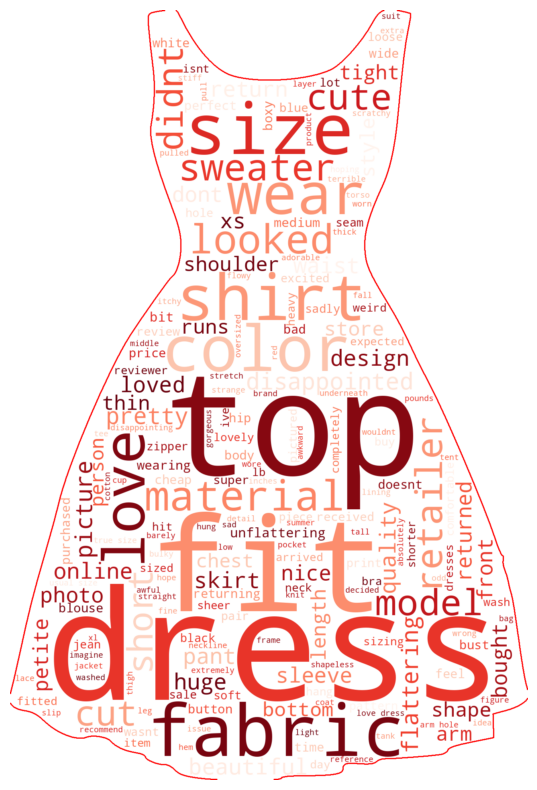

In [ ]:
wordcloud_negative = WordCloud(
    width=800, height=800, background_color="white",
    colormap="Reds", mask=custom_mask, contour_color="red", contour_width=2
).generate(negative_text)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis("off")
#plt.title("Word Cloud - Dress Shape (Negative Reviews)", fontsize=14)
plt.show()

## Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
#TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)#take 5k
X = vectorizer.fit_transform(df_cleaned["Cleaned Review"])

y = df_cleaned["Sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": MultinomialNB()
}

results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    results[model_name] = {
        "model": model,
        "accuracy": accuracy,
        "classification_report": classification_report(y_test, y_pred, digits=4),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

Training Logistic Regression...
Training Random Forest...
Training Naive Bayes...


In [ ]:
#report
for model_name, result in results.items():
    print(f"\n {model_name} Classification Report:\n")
    print(result["classification_report"])
    print("="*80)


 Logistic Regression Classification Report:

              precision    recall  f1-score   support

    Negative     0.6034    0.4383    0.5077       486
     Neutral     0.4174    0.1749    0.2465       549
    Positive     0.8603    0.9717    0.9126      3493

    accuracy                         0.8178      4528
   macro avg     0.6270    0.5283    0.5556      4528
weighted avg     0.7790    0.8178    0.7884      4528


 Random Forest Classification Report:

              precision    recall  f1-score   support

    Negative     0.6257    0.2407    0.3477       486
     Neutral     0.4848    0.0291    0.0550       549
    Positive     0.8059    0.9940    0.8901      3493

    accuracy                         0.7962      4528
   macro avg     0.6388    0.4213    0.4309      4528
weighted avg     0.7477    0.7962    0.7307      4528


 Naive Bayes Classification Report:

              precision    recall  f1-score   support

    Negative     0.7167    0.0885    0.1575       486
     

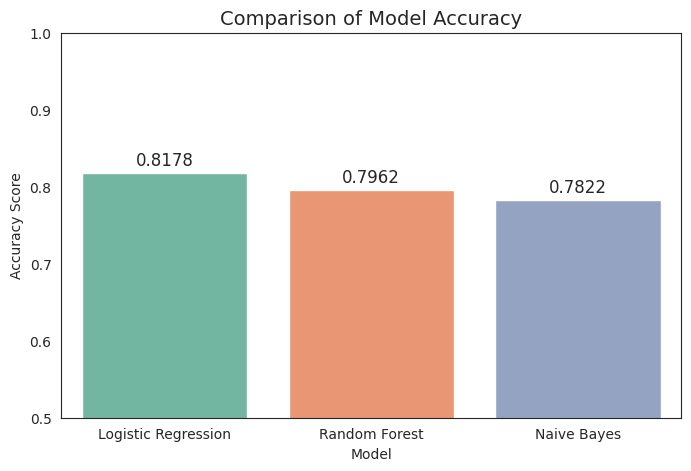

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=list(results.keys()), y=[results[m]["accuracy"] for m in results], palette="Set2")

for i, (model_name, result) in enumerate(results.items()):
    ax.text(i, result["accuracy"] + 0.01, f'{result["accuracy"]:.4f}', ha='center', fontsize=12)

plt.title("Comparison of Model Accuracy", fontsize=14)
plt.xlabel("Model")
plt.ylabel("Accuracy Score")
plt.ylim(0.5, 1.0)
plt.show()

In [ ]:
#Best
best_model_name = max(results, key=lambda m: results[m]["accuracy"])
best_model = results[best_model_name]["model"]

print(f"Best Model: {best_model_name} with Accuracy {results[best_model_name]['accuracy']:.4f}")

Best Model: Logistic Regression with Accuracy 0.8178


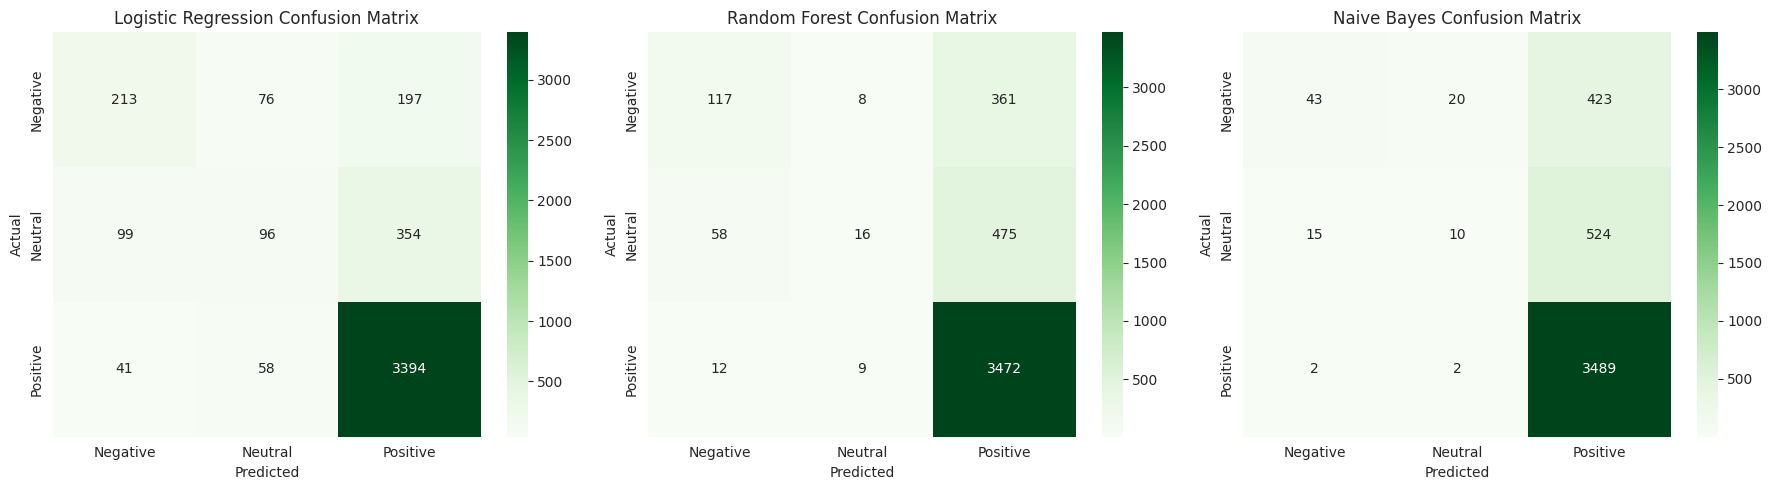

In [ ]:
#Matrix
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (model_name, result) in zip(axes, results.items()):
    conf_matrix = result["confusion_matrix"]
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=models["Logistic Regression"].classes_, yticklabels=models["Logistic Regression"].classes_, ax=ax)
    ax.set_title(f"{model_name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [ ]:
#test
new_reviews = [
    "I absolutely love this dress! The fabric is soft and comfortable.",
    "The size was way too big and the color was different from the picture.",
    "It is okay, but nothing special. The material is average."
]
new_reviews_cleaned = [clean_text(review) for review in new_reviews]
new_reviews_vectorized = vectorizer.transform(new_reviews_cleaned)
predictions = best_model.predict(new_reviews_vectorized)

#output
for review, sentiment in zip(new_reviews, predictions):
    print(f"Review: {review} \nPredicted Sentiment: {sentiment}\n")

Review: I absolutely love this dress! The fabric is soft and comfortable. 
Predicted Sentiment: Positive

Review: The size was way too big and the color was different from the picture. 
Predicted Sentiment: Positive

Review: It is okay, but nothing special. The material is average. 
Predicted Sentiment: Neutral



# Customer Analysis

In [ ]:
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
tm = df_cleaned.copy()

## Predictive Modeling

In [ ]:
#TextBlob
tm["Polarity"] = tm["Review Text"].apply(lambda x: TextBlob(x).sentiment.polarity)
tm["Subjectivity"] = tm["Review Text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

#complexity
tm["Word Count"] = tm["Review Text"].apply(lambda x: len(re.findall(r'\b\w+\b', x)))  # 计算单词数
tm["Sentence Count"] = tm["Review Text"].apply(lambda x: len(re.split(r'[.!?]', x)))  # 计算句子数
tm["Avg Word Length"] = tm["Review Text"].apply(lambda x: np.mean([len(word) for word in re.findall(r'\b\w+\b', x)]))


#TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(tm["Cleaned Review"])

#combined features
X_features = np.hstack((X_text.toarray(), tm[["Rating", "Polarity", "Subjectivity", "Word Count", "Avg Word Length"]].values))
y = tm["Recommended IND"]

#data
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

#train
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#report
y_pred = model.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 0.9423586572438163

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.84       827
           1       0.97      0.96      0.96      3701

    accuracy                           0.94      4528
   macro avg       0.90      0.90      0.90      4528
weighted avg       0.94      0.94      0.94      4528



## LDA

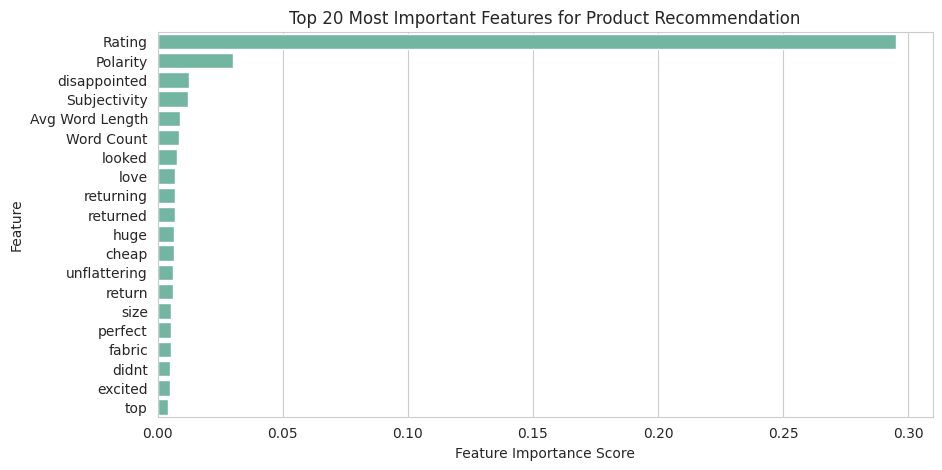

In [ ]:
#feature importance
feature_names = list(vectorizer.get_feature_names_out()) + ["Rating", "Polarity", "Subjectivity", "Word Count", "Avg Word Length"]
feature_importance = model.feature_importances_
top_features = sorted(zip(feature_importance, feature_names), reverse=True)[:20]

#visual
plt.figure(figsize=(10, 5))
sns.set_palette("Set2")
sns.set_style("whitegrid")
sns.barplot(x=[f[0] for f in top_features], y=[f[1] for f in top_features])
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Most Important Features for Product Recommendation")
plt.show()

In [ ]:
#LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda.fit_transform(X_text)

#top word
top_words = 10
words = np.array(vectorizer.get_feature_names_out())
topics = []
for topic_idx, topic in enumerate(lda.components_):
    topic_words = [words[i] for i in topic.argsort()[:-top_words - 1:-1]]
    topics.append(", ".join(topic_words))
    print(f" Topic {topic_idx+1}: {', '.join(topic_words)}")

 Topic 1: dress, shirt, top, fabric, price, looked, cute, returning, return, quality
 Topic 2: dress, size, fit, petite, love, wear, xs, top, length, fits
 Topic 3: love, dress, wear, jeans, comfortable, perfect, fit, top, size, soft
 Topic 4: size, suit, dress, fit, waist, love, top, pants, fabric, flattering
 Topic 5: top, dress, size, love, fit, fabric, color, sweater, shirt, beautiful


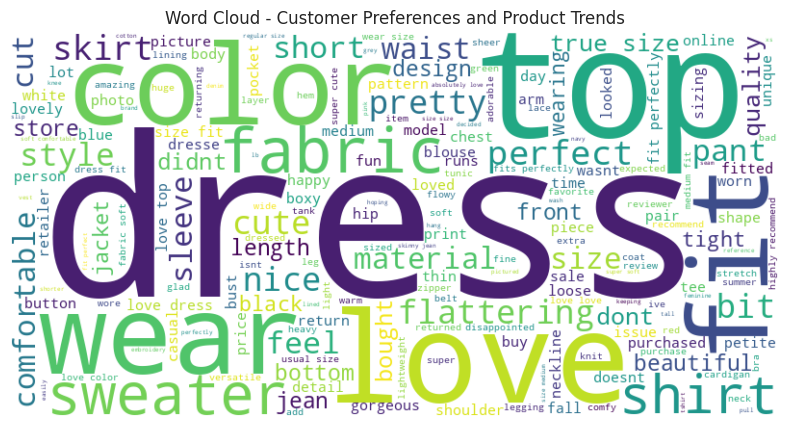

In [ ]:
#wordcloud for LDA
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(tm["Cleaned Review"]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Customer Preferences and Product Trends")
plt.show()